<a href="https://colab.research.google.com/github/k-ele/for-share/blob/master/convert_h5_to_pb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learningアプリケーション開発 (2) TensorFlow with Python
TensorFlowモデルに変換してPythonで使用してみる

https://qiita.com/iwatake2222/items/80fc73ff23d8f51650f5

# 環境設定

In [1]:
from google.colab import drive
drive.mount('/content/drive')
!ls

Mounted at /content/drive
drive  sample_data


# モデル変換 (Keras(H5) -> Tensorflow Saved model(pb))

In [2]:
%tensorflow_version 2.x
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

print(tf.__version__)

# Download Keras H5 model
!wget -O conv_mnist.h5 "https://drive.google.com/uc?export=download&id=1OLR1n5Pq0CGPz7Bw5pad-fvYsgCnKvHh" 

# Load Keras H5 model, then save as Tensorflow saved model(pb)
loaded_model = tf.keras.models.load_model("conv_mnist.h5")
loaded_model.save("conv_mnist_saved_model", save_format="tf")
# tf.saved_model.save(model, 'saved_model')

!ls -la conv_mnist_saved_model
!tar zcvf conv_mnist_saved_model.tar.gz  conv_mnist_saved_model

2.4.1
--2021-02-17 03:57:02--  https://drive.google.com/uc?export=download&id=1OLR1n5Pq0CGPz7Bw5pad-fvYsgCnKvHh
Resolving drive.google.com (drive.google.com)... 172.217.7.174, 2607:f8b0:4004:800::200e
Connecting to drive.google.com (drive.google.com)|172.217.7.174|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-04-7s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/902cofmigh7u80q1jaf9jjre2nhdkq6e/1613534175000/06137305555544994122/*/1OLR1n5Pq0CGPz7Bw5pad-fvYsgCnKvHh?e=download [following]
--2021-02-17 03:57:03--  https://doc-04-7s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/902cofmigh7u80q1jaf9jjre2nhdkq6e/1613534175000/06137305555544994122/*/1OLR1n5Pq0CGPz7Bw5pad-fvYsgCnKvHh?e=download
Resolving doc-04-7s-docs.googleusercontent.com (doc-04-7s-docs.googleusercontent.com)... 142.250.73.225, 2607:f8b0:4004:82a::2001
Connecting to doc-04-7s-docs.googleusercontent.com (doc-04-7s-d

## Check model information

In [3]:
!saved_model_cli show --dir conv_mnist_saved_model  --tag_set serve --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['input_image'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 28, 28, 1)
      name: serving_default_input_image:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['output_scores'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 10)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


# Tensorflow saved modelによる推論テスト

--2021-02-17 03:57:12--  https://drive.google.com/uc?export=download&id=1-3yb3qCrN8M6Bdj7ZZ9UMjONh34R2W_A
Resolving drive.google.com (drive.google.com)... 172.217.7.174, 2607:f8b0:4004:800::200e
Connecting to drive.google.com (drive.google.com)|172.217.7.174|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0c-7s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/iaqv7ths6r39tj903ilq0b5v0cmo8kg3/1613534175000/06137305555544994122/*/1-3yb3qCrN8M6Bdj7ZZ9UMjONh34R2W_A?e=download [following]
--2021-02-17 03:57:12--  https://doc-0c-7s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/iaqv7ths6r39tj903ilq0b5v0cmo8kg3/1613534175000/06137305555544994122/*/1-3yb3qCrN8M6Bdj7ZZ9UMjONh34R2W_A?e=download
Resolving doc-0c-7s-docs.googleusercontent.com (doc-0c-7s-docs.googleusercontent.com)... 142.250.73.225, 2607:f8b0:4004:82a::2001
Connecting to doc-0c-7s-docs.googleusercontent.com (doc-0c-7s-docs.go

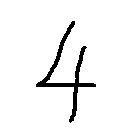

predicted number is 4 [1.00]


In [4]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np

# Read input image
!wget -O 4.jpg  "https://drive.google.com/uc?export=download&id=1-3yb3qCrN8M6Bdj7ZZ9UMjONh34R2W_A" 
img = cv2.imread("4.jpg")
cv2_imshow(img)

# Pre process
## グレースケール化、リサイズ、白黒判定、価範囲を0～255 -> 0.0～1.0
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img, (28, 28))
img = 255 - img
img = img / 255.
img = img.astype(np.float32)
input_tensor = img.reshape(1, img.shape[0], img.shape[1], 1)
input_tensor = tf.convert_to_tensor(input_tensor)

# Load model
loaded_model = tf.saved_model.load("conv_mnist_saved_model")
infer = loaded_model.signatures["serving_default"]
output_name = list(infer.structured_outputs.keys())[0]

# Inference
output_tensor = infer(input_tensor)[output_name]

scores = output_tensor.numpy()
result = np.argmax(scores[0])
print("predicted number is {} [{:.2f}]".format(result, scores[0][result]))

In [5]:
# Save to google drive
!cp conv_mnist_saved_model.tar.gz  "/content/drive/My Drive/test_data/number/"

# Download to local
from google.colab import files
files.download( "./conv_mnist_saved_model.tar.gz")

cp: cannot create regular file '/content/drive/My Drive/test_data/number/': No such file or directory


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>